In [1]:
import os
import h2o
import pandas as pd
import numpy as np
from h2o.automl import H2OAutoML
import tools
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import StratifiedKFold

In [3]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  ---------------------------------
H2O_cluster_uptime:         25 secs
H2O_cluster_timezone:       America/New_York
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.40.0.4
H2O_cluster_version_age:    1 month and 30 days
H2O_cluster_name:           H2O_from_python_TaejunJang_xyeoj2
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.854 Gb
H2O_cluster_total_cores:    16
H2O_cluster_allowed_cores:  16
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.10.2 final
--------------------------  ---------------------------------

In [4]:
# Load data
df = pd.read_csv('duke_vital_model_imputed.csv')
df["PostCond"] = df["PostCond"].apply(lambda x: 0 if x == 1 else 1)

In [5]:
subj_dict = tools.create_subj_dict(df)
subj_labels = np.array([np.array(list([key, subj_dict[key][0]["PostCond"]])) for key in subj_dict.keys()])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
patient_split = skf.split(subj_labels[:, 0], subj_labels[:, 1])

train_patient_index = dict()
test_patient_index = dict()
cnt = 0
for train_i, test_i in patient_split:
    train_patient_index[cnt] = train_i
    test_patient_index[cnt] = test_i
    cnt += 1

In [6]:
def filterer(pair):
    key, value = pair
    if len(value) >= 2:
        return True
    return False

In [7]:
train_subj_dict = {patient: subj_dict[patient] for patient in subj_dict.keys() if patient in subj_labels[train_patient_index[0], 0]}
test_subj_dict = {patient: subj_dict[patient] for patient in subj_dict.keys() if patient in subj_labels[test_patient_index[0], 0]}

train_df = tools.subj_dict_to_df(train_subj_dict)
test_df = tools.subj_dict_to_df(test_subj_dict)

trends = tools.return_trends(train_df, [[2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13]], ["DIASBP_R", "PULSE_R", "SYSBP_R", "WEIGHT_R", "CREATININE_R", "HDL_R", "LDL_R", "TOTCHOL_R", "wbc", "gluc", "tprot", "alb", "ast", "alt", "tbil", "cr", "ptinr"])

train_col_names = list(train_df.drop(labels=["RSUBJID", "PostCond"], axis=1).keys())
test_col_names = list(test_df.drop(labels=["RSUBJID", "PostCond"], axis=1).keys())

imputer = IterativeImputer(random_state=42)

X_train_for_imputed = imputer.fit_transform(train_df.drop(labels=["RSUBJID", "PostCond"], axis=1).to_numpy())
X_test_for_imputed = imputer.transform(test_df.drop(labels=["RSUBJID", "PostCond"], axis=1).to_numpy())

imputed_train_df = pd.DataFrame(X_train_for_imputed, columns=train_col_names)
imputed_test_df = pd.DataFrame(X_test_for_imputed, columns=test_col_names)

imputed_train_df["RSUBJID"] = train_df["RSUBJID"]
imputed_train_df["PostCond"] = train_df["PostCond"]
imputed_test_df["RSUBJID"] = test_df["RSUBJID"]
imputed_test_df["PostCond"] = test_df["PostCond"]

imputed_train_subj_dict = tools.create_subj_dict(imputed_train_df)
imputed_test_subj_dict = tools.create_subj_dict(imputed_test_df)

filtered_imputed_train_subj_dict = dict(filter(filterer, imputed_train_subj_dict.items()))
filtered_imputed_test_subj_dict = dict(filter(filterer, imputed_test_subj_dict.items()))

normalized_train_dict = tools.dist_from_age_mean(filtered_imputed_train_subj_dict, trends)
normalized_test_dict = tools.dist_from_age_mean(filtered_imputed_test_subj_dict, trends)

linearized_train_dict = tools.dict_to_linfit(normalized_train_dict, trend_cols=["DIASBP_R", "PULSE_R", "SYSBP_R", "WEIGHT_R", "CREATININE_R", "HDL_R", "LDL_R", "TOTCHOL_R", "wbc", "gluc", "tprot", "alb", "ast", "alt", "tbil", "ptinr"])
linearized_test_dict = tools.dict_to_linfit(normalized_test_dict, trend_cols=["DIASBP_R", "PULSE_R", "SYSBP_R", "WEIGHT_R", "CREATININE_R", "HDL_R", "LDL_R", "TOTCHOL_R", "wbc", "gluc", "tprot", "alb", "ast", "alt", "tbil", "ptinr"])

linearized_train_df = tools.lin_dict_to_df(linearized_train_dict)
linearized_test_df = tools.lin_dict_to_df(linearized_test_dict)

X = linearized_train_df.drop(labels=["RSUBJID"], axis=1)
X_test = linearized_test_df.drop(labels=["RSUBJID"], axis=1)

C:\Users\TaejunJang\AppData\Local\Temp\ipykernel_20252\3045801210.py:34: RankWarning: Polyfit may be poorly conditioned
  linearized_train_dict = tools.dict_to_linfit(normalized_train_dict, trend_cols=["DIASBP_R", "PULSE_R", "SYSBP_R", "WEIGHT_R", "CREATININE_R", "HDL_R", "LDL_R", "TOTCHOL_R", "wbc", "gluc", "tprot", "alb", "ast", "alt", "tbil", "ptinr"])
C:\Users\TaejunJang\AppData\Local\Temp\ipykernel_20252\3045801210.py:34: RankWarning: Polyfit may be poorly conditioned
  linearized_train_dict = tools.dict_to_linfit(normalized_train_dict, trend_cols=["DIASBP_R", "PULSE_R", "SYSBP_R", "WEIGHT_R", "CREATININE_R", "HDL_R", "LDL_R", "TOTCHOL_R", "wbc", "gluc", "tprot", "alb", "ast", "alt", "tbil", "ptinr"])
C:\Users\TaejunJang\AppData\Local\Temp\ipykernel_20252\3045801210.py:34: RankWarning: Polyfit may be poorly conditioned
  linearized_train_dict = tools.dict_to_linfit(normalized_train_dict, trend_cols=["DIASBP_R", "PULSE_R", "SYSBP_R", "WEIGHT_R", "CREATININE_R", "HDL_R", "LDL_R", "T

In [8]:
categorical_columns = ["RACE_G", "GENDER", "HXCOPD", "HXDIAB", "HXHTN", "HXHYL", "HXSMOKE"]

X["RACE_G"] = X["RACE_G"].astype(int)
X_test["RACE_G"] = X_test["RACE_G"].astype(int)

X = h2o.H2OFrame(X)
X_test = h2o.H2OFrame(X_test)

X["RACE_G"] = X["RACE_G"].asfactor()
X["GENDER"] = X["GENDER"].asfactor()
X["HXCOPD"] = X["HXCOPD"].asfactor()
X["HXDIAB"] = X["HXDIAB"].asfactor()
X["HXHTN"] = X["HXHTN"].asfactor()
X["HXHYL"] = X["HXHYL"].asfactor()
X["HXSMOKE"] = X["HXSMOKE"].asfactor()
X["PostCond"] = X["PostCond"].asfactor()

X_test["RACE_G"] = X_test["RACE_G"].asfactor()
X_test["GENDER"] = X_test["GENDER"].asfactor()
X_test["HXCOPD"] = X_test["HXCOPD"].asfactor()
X_test["HXDIAB"] = X_test["HXDIAB"].asfactor()
X_test["HXHTN"] = X_test["HXHTN"].asfactor()
X_test["HXHYL"] = X_test["HXHYL"].asfactor()
X_test["HXSMOKE"] = X_test["HXSMOKE"].asfactor()
X_test["PostCond"] = X_test["PostCond"].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [9]:
aml = H2OAutoML(max_models=25, balance_classes=True, seed=1)
aml.train(training_frame=X, y='PostCond')

AutoML progress: |█
12:16:50.658: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_1_20230627_121650


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       15/25
# GBM base models (used / total)           9/12
# DRF base models (used / total)           2/2
# DeepLearning base models (used / total)  3/10
# GLM base models (used / total)           1/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.09273550298869024
RMSE: 0.3045250449284759
LogLoss: 0.3170354326695208
AUC: 0.9780429764269779
AUCPR: 0.9009676638568793
Gini: 0.9560859528539558
Null degrees of freedom: 10032
Residual degrees of freedom: 10017
Null deviance: 10990.907026442757
Residual deviance: 6361.6329919466025
AIC: 6393.6329919466025

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32487393888787924
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      7409  245   0.032    (245.0/7654.0)
1      200   2179  0.0841   (200.0/2379.0)
Total  7609  2424  0.0444   (445.0/10033.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.324874     0.90735   178
max f2                       0.282155     0.931499  201
max f0point5                 0.336944     0.905264  171
max accuracy                 0.328324     0.955746  176
max precision                0.850154     1         0
max recall                   0.154416     1         289
max specificity              0.850154     1         0
max absolute_mcc             0.324874     0.878264  178
max min_per_class_accuracy   0.300644     0.948132  191
max mean_per_class_accuracy  0.294174     0.949549  194
max tns                      0.850154     7654      0
max fns                      0.850154     2378      0
max fps                      0.00153872   7654      399
max tps                      0.154416     2379      289
max tnr                      0.850154     1         0
max fnr                      0.850154     0.99958   0
max fpr                      0.00153872   1         399
max tpr                      0.154416     1         289

Gains/Lift Table: Avg response rate: 23.71 %, avg score: 24.66 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100668                   0.795991           4.21732    4.21732            1                0.806232   1                           0.806232            0.0424548       0.0424548                  321.732   321.732            0.0424548
2        0.0200339                   0.787458           4.21732    4.21732            1                0.791051   1                           0.798679            0.0420345       0.0844893                  321.732   321.732            0.0844893
3        0.030001                    0.779293           4.21732    4.21732            1                0.783365   1                           0.793592            0.0420345       0.126524                   321.732   321.732            0.126524
4        0.0400678                   0.772141      

In [10]:
best_model = aml.get_best_model()
print(best_model)

Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_1_20230627_121650


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       15/25
# GBM base models (used / total)           9/12
# DRF base models (used / total)           2/2
# DeepLearning base models (used / total)  3/10
# GLM base models (used / total)           1/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.09273550298869024
RMSE: 0.3045250449284759
LogLoss: 0.3170354326695208
AUC: 0.9780429764269779
AUCPR: 0.9009676638568793
Gini: 0.95608

In [11]:
# Convert the test data to H2OFrame
X_test_h2o = h2o.H2OFrame(linearized_test_df.drop(labels=["RSUBJID"], axis=1))
X_test_h2o["RACE_G"] = X_test_h2o["RACE_G"].ascharacter()  
X_test_h2o["RACE_G"] = X_test_h2o["RACE_G"].asfactor()  
X_test_h2o["GENDER"] = X_test_h2o["GENDER"].asfactor()
X_test_h2o["HXCOPD"] = X_test_h2o["HXCOPD"].asfactor()
X_test_h2o["HXDIAB"] = X_test_h2o["HXDIAB"].asfactor()
X_test_h2o["HXHTN"] = X_test_h2o["HXHTN"].asfactor()
X_test_h2o["HXHYL"] = X_test_h2o["HXHYL"].asfactor()
X_test_h2o["HXSMOKE"] = X_test_h2o["HXSMOKE"].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [12]:
# Perform predictions
predictions = best_model.predict(X_test_h2o)
probabilities = predictions["p1"].as_data_frame()

# Convert probabilities to percentages
probabilities_percentage = (probabilities * 100).round(2)

print(probabilities_percentage)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


c:\Users\TaejunJang\AppData\Local\Programs\Python\Python310\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'RACE_G' has levels not trained on: ["1.005", "1.0504", "1.0704", "1.0801", "1.1199", "1.1276", "1.1555", "1.1713", "1.1745", "1.2447", ...7 not listed..., "1.2991", "1.3077", "1.3134", "1.3475", "1.3688", "1.377", "1.385", "1.4054", "1.5367", "1.6719"]
  warnings.warn(w)


         p1
0     17.09
1     21.12
2     23.30
3     17.47
4     21.35
...     ...
1696  26.37
1697   4.04
1698   7.28
1699  10.88
1700  13.83

[1701 rows x 1 columns]


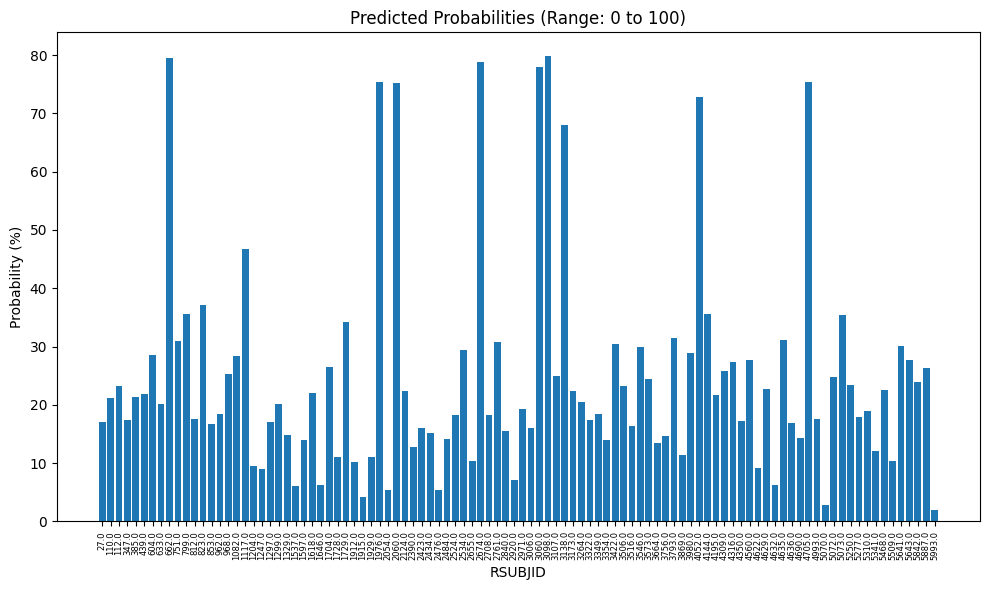

In [16]:
import matplotlib.pyplot as plt

start_index = 0 
end_index = start_index + 100 
rsubjids = linearized_test_df["RSUBJID"].tolist()[start_index:end_index]
probabilities_range = probabilities_percentage[start_index:end_index]

# Plot the probabilities
x = range(len(rsubjids))
y = probabilities_range["p1"].tolist()

plt.figure(figsize=(10, 6))
plt.bar(x, y)
plt.xticks(x, rsubjids, rotation='vertical', fontsize=6)
plt.xlabel('RSUBJID')
plt.ylabel('Probability (%)')
plt.title('Predicted Probabilities (Range: {} to {})'.format(start_index, end_index))
plt.tight_layout()
plt.show()